In [95]:
import os
import glob
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

Table 0

In [96]:
files_folder = "FixationData"
files = []
raw_files = []
dist_s = []
dist_sR = []

for file in glob.glob(os.path.join(files_folder ,"*.txt")):
    rawTxt = pd.read_csv(file, delimiter=',')

    # calculate intra-ROI saccades
    tempTxt = rawTxt.loc[rawTxt['Fix.objectType'] == rawTxt['Fix.objectType'].shift(1)].reset_index()
    
    # cal saccard distance for tempTxt
    arr = tempTxt[tempTxt.columns[8:11]].values
    dist_mat = cdist(arr,arr)
    txt_dist = pd.DataFrame.from_dict(dist_mat)
    for n in range(len(txt_dist)):
        if n == len(txt_dist) - 1:
            break
        else:
            dist_s.append(txt_dist[n][n+1])

    dist_s.insert(0, 0)
    tempTxt.insert(5,'saccard_distance', dist_s)
    dist_s.clear()

    # cal saccard distance for rawTxt
    arrR = rawTxt[rawTxt.columns[7:10]].values
    dist_matR = cdist(arrR,arrR)
    txt_distR = pd.DataFrame.from_dict(dist_matR)
    for n in range(len(txt_distR)):
        if n == len(txt_distR) - 1:
            break
        else:
            dist_sR.append(txt_distR[n][n+1])

    dist_sR.insert(0, 0)
    rawTxt.insert(5,'saccard_distance', dist_sR)
    dist_sR.clear()

    # cal saccade duration
    tempTxt.insert(6,'saccade_duration',tempTxt['Fix.startTime'] - tempTxt['Fix.endTime'].shift())
    rawTxt.insert(6,'saccade_duration',rawTxt['Fix.startTime'] - rawTxt['Fix.endTime'].shift())

    files.append(tempTxt)
    # with both inter and intra ROI
    raw_files.append(rawTxt)


In [97]:
df = pd.concat(files)
df.drop(['Fix.startTime', 'Fix.endTime', 'Fix.duration', 'Fix.x', 'Fix.y', 'Fix.z'], axis=1, inplace=True)
df.rename(columns={'Fix.objectType':'ROI'}, inplace=True)
df = df.fillna(0)

df.to_csv('t0.csv', index=False)

In [98]:
raw_df = pd.concat(raw_files)
raw_df.drop(['Fix.startTime', 'Fix.endTime', 'Fix.duration', 'Fix.x', 'Fix.y', 'Fix.z'], axis=1, inplace=True)
raw_df.rename(columns={'Fix.objectType':'ROI'}, inplace=True)
raw_df = raw_df.fillna(0)

raw_df.to_csv('rawT.csv', index=False)

Table 1

In [99]:
t1 = df.groupby(['Participant', 'heritage', 'Text on-off', 'Audio on-off', 'ROI'], 
    as_index=False).agg({'saccard_distance':['count', 'sum', 'mean'], 
    'saccade_duration':['sum', 'mean']})
t1.columns = ['Participant No.', 'Scene No.', 'Text Cond.', 'Audio Cond.', 'ROI category', 
    'Saccade Count', 'Total Saccade Distance', 'Average Saccade Distance', 'Total Saccade Duration', 
    'Average Saccade Duration']
t1 = t1.reset_index()

t1.to_csv('t1.csv', index=False)

In [153]:
# Show sd
t1_sd = df.groupby(['Participant', 'heritage', 'Text on-off', 'Audio on-off', 'ROI'], 
    as_index=False).agg({'saccard_distance':['count', 'sum', 'mean', 'std'], 
    'saccade_duration':['sum', 'mean', 'std']})
# t1_sd.columns = ['Participant No.', 'Scene No.', 'Text Cond.', 'Audio Cond.', 'ROI category', 
#     'Saccade Count', 'Total Saccade Distance', 'Average Saccade Distance', 'Saccade Distance Sd'
#     'Total Saccade Duration', 'Average Saccade Duration', 'Saccade Duration']
t1_sd = t1_sd.reset_index()
print(t1_sd)
t1_sd.to_csv('t1_sd.csv', index=False)




     index Participant heritage Text on-off Audio on-off                  ROI  \
                                                                                
0        0       exp_1   Scene1         Off          Off  Culturual  Heritage   
1        1       exp_1   Scene1         Off          Off               Others   
2        2       exp_1   Scene1         Off          Off         Tamed nature   
3        3       exp_1   Scene1         Off          Off                Urban   
4        4       exp_1   Scene2         Off           On  Culturual  Heritage   
...    ...         ...      ...         ...          ...                  ...   
1302  1302       exp_9   Scene7          On          Off  Culturual  Heritage   
1303  1303       exp_9   Scene7          On          Off                 Text   
1304  1304       exp_9   Scene8          On           On               Others   
1305  1305       exp_9   Scene8          On           On                 Text   
1306  1306       exp_9   Sce

Check Normality

      KS-p-value          AD-Critical-values    SW-p-value
0   0.000000e+00  108.07605501647504 > 0.785  4.809129e-39
1   0.000000e+00    90.0939213559559 > 0.785  1.262187e-37
2  9.090808e-322   67.65498238547707 > 0.785  1.373146e-40
3   0.000000e+00   72.15416312411026 > 0.785  7.112066e-35
4   0.000000e+00   135.1824593009776 > 0.785  0.000000e+00


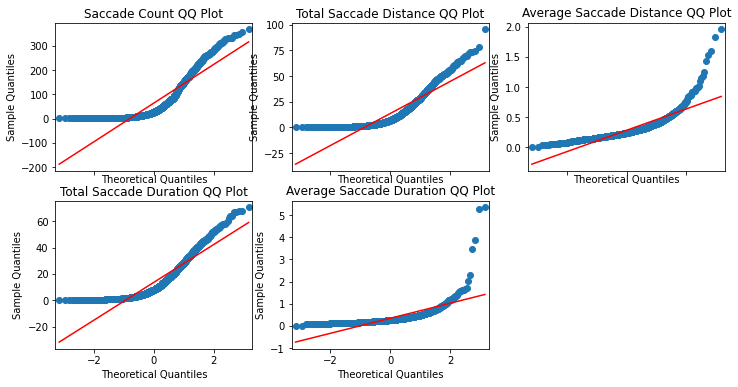

In [100]:
ks_p_value = []
ad_critical_values = []
sw_p_value = []
col_name = t1[['Saccade Count', 'Total Saccade Distance', 'Average Saccade Distance', 'Total Saccade Duration','Average Saccade Duration']].columns
qq_col_list = ['Saccade Count', 'Total Saccade Distance', 'Average Saccade Distance', 'Total Saccade Duration','Average Saccade Duration', 'Empty']

fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(4*3, 2*3))
for k, ax in zip(qq_col_list, np.ravel(axes)):
    if k == 'Empty':
        ax.set_visible(False)
    else:
        sm.qqplot(t1[k], line='s', ax=ax)
        ax.set_title(f'{k} QQ Plot')

for i in col_name:
    """
    Kolmogorov-Smirnov test
    Since the p-value is significantly less than 0.05, we reject the null hypothesis and accept the alternative hypothesis 
    that two samples tested are not from the same cumulative distribution, meaning that it is not normally distributed.
    """
    result2 = stats.kstest(t1[i], cdf='norm')
    # print(f"K-S statistic: {result2[0]}")
    # print(f"p-value: {result2[1]}")
    ks_p_value.append(result2[1])

    """
    Anderson-Darling test
    Test our hypothesis at the 5% level.
    Since the computer A-D test statistic is larger than the critical value,
    we reject the null hypothesis and conclude that the sample data comes from a non-normal distribution.
    """
    result = stats.anderson(t1[i], dist='norm')
    # print(f"A-D statistic: {result[0]}")
    # print(f"Critical values: {result[1]}")
    # print(f"Significance levels: {result[2]}")
    ad_critical_values.append(f'{result[0]} > {result[1][2]}')

    """
    Shapiro-Wilk test
    Given the small p-value which is smaller than 0.05 (<0.05), 
    we reject the null hypothesis and conclude that the sample sample is significantly different from a normal distribution.
    """
    result3 = stats.shapiro(t1[i])
    # print(f"S-W statistic: {result3[0]}")
    # print(f"p-value: {result3[1]}")
    sw_p_value.append(result3[1])

check_normality = pd.DataFrame(zip(ks_p_value, ad_critical_values, sw_p_value),
                    columns =['KS-p-value', 'AD-Critical-values', 'SW-p-value'])
print(check_normality)


Data are not normally distributed

In [101]:
condition = [
    (t1['Audio Cond.'] == "Off") & (t1['Text Cond.'] == "On"),
    (t1['Audio Cond.'] == "On") & (t1['Text Cond.'] == "Off"),
    (t1['Audio Cond.'] == "Off") & (t1['Text Cond.'] == "Off"),
    (t1['Audio Cond.'] == "On") & (t1['Text Cond.'] == "On")
]

values = ['text', 'audio', 'baseline', 'text+audio']
t1['condition'] = np.select(condition, values)

t1Text = t1.loc[(t1['Audio Cond.'] == "Off") & (t1['Text Cond.'] == "On")]
t1Audio = t1.loc[(t1['Audio Cond.'] == "On") & (t1['Text Cond.'] == "Off")]
t1Base = t1.loc[(t1['Audio Cond.'] == "Off") & (t1['Text Cond.'] == "Off")]
t1At = t1.loc[(t1['Audio Cond.'] == "On") & (t1['Text Cond.'] == "On")]

Mann-Whitney U-tests

In [102]:
MW_p_value = []
MW_p_value_2 = []
"""
Comparison Pair 1: baseline (A) vs. audio (C)
Comparison Pair 2: text (B) vs. text+audio (D)
"""
# Mann-Whitney U-tests
for i in col_name:
    # Pair 1
    stat, p_value = stats.mannwhitneyu(t1Base[i], t1Audio[i], alternative='two-sided')
    print(f'Pair 1 {i}: Statistics={stat:.2f}, p={p_value:.2f}')
    MW_p_value.append(p_value)
    # Level of significance
    alpha = 0.05
    # conclusion
    if p_value < alpha:
        print('Reject Null Hypothesis (Significant difference between two samples)')
    else:
        print('Do not Reject Null Hypothesis (No significant difference between two samples)')

    # Pair 2
    stat2, p_value_2 = stats.mannwhitneyu(t1Text[i], t1At[i], alternative='two-sided')
    print(f'Pair 2 {i}: Statistics={stat2:.2f}, p={p_value_2:.2f}')
    MW_p_value_2.append(p_value_2)
    # Level of significance
    alpha = 0.05
    # conclusion
    if p_value_2 < alpha:
        print('Reject Null Hypothesis (Significant difference between two samples)\n')
    else:
        print('Do not Reject Null Hypothesis (No significant difference between two samples)\n')

Pair 1 Saccade Count: Statistics=46188.00, p=0.53
Do not Reject Null Hypothesis (No significant difference between two samples)
Pair 2 Saccade Count: Statistics=63771.00, p=0.68
Do not Reject Null Hypothesis (No significant difference between two samples)

Pair 1 Total Saccade Distance: Statistics=47391.00, p=0.23
Do not Reject Null Hypothesis (No significant difference between two samples)
Pair 2 Total Saccade Distance: Statistics=63012.00, p=0.90
Do not Reject Null Hypothesis (No significant difference between two samples)

Pair 1 Average Saccade Distance: Statistics=49345.00, p=0.03
Reject Null Hypothesis (Significant difference between two samples)
Pair 2 Average Saccade Distance: Statistics=60441.00, p=0.42
Do not Reject Null Hypothesis (No significant difference between two samples)

Pair 1 Total Saccade Duration: Statistics=47702.50, p=0.18
Do not Reject Null Hypothesis (No significant difference between two samples)
Pair 2 Total Saccade Duration: Statistics=62271.00, p=0.89
Do 

Each ROI

In [141]:
pair1_ROI = ['Culturual  Heritage', 'Nature', 'Others', 'Tamed nature', 'Urban']
pair2_ROI = ['Culturual  Heritage', 'Nature', 'Others', 'Tamed nature', 'Text', 'Urban']

"""
Comparison Pair 1: baseline (A) vs. audio (C)
Comparison Pair 2: text (B) vs. text+audio (D)
"""
# Mann-Whitney U-tests
for j in pair1_ROI:
    for i in col_name:
        # Pair 1
        stat, p_value = stats.mannwhitneyu(t1Base[i].loc[t1Base['ROI category'] == j], t1Audio[i].loc[t1Audio['ROI category'] == j], alternative='two-sided')
        print(f'Pair 1 {i} for ROI "{j}": Statistics={stat:.2f}, p={p_value:.2f}')

        # Level of significance
        alpha = 0.05
        # conclusion
        if p_value < alpha:
            print('Reject Null Hypothesis (Significant difference between two samples)\n')
        else:
            print('Do not Reject Null Hypothesis (No significant difference between two samples)\n')

for k in pair2_ROI:
    for i in col_name:
        # Pair 2
        stat2, p_value_2 = stats.mannwhitneyu(t1Text[i].loc[t1Text['ROI category'] == k], t1At[i].loc[t1At['ROI category'] == k], alternative='two-sided')
        print(f'Pair 2 {i} for ROI "{k}": Statistics={stat2:.2f}, p={p_value_2:.2f}')
        # Level of significance
        alpha = 0.05
        # conclusion
        if p_value_2 < alpha:
            print('Reject Null Hypothesis (Significant difference between two samples)\n')
        else:
            print('Do not Reject Null Hypothesis (No significant difference between two samples)\n')




Pair 1 Saccade Count for ROI "Culturual  Heritage": Statistics=2159.50, p=0.23
Do not Reject Null Hypothesis (No significant difference between two samples)

Pair 1 Total Saccade Distance for ROI "Culturual  Heritage": Statistics=2236.00, p=0.37
Do not Reject Null Hypothesis (No significant difference between two samples)

Pair 1 Average Saccade Distance for ROI "Culturual  Heritage": Statistics=2561.00, p=0.65
Do not Reject Null Hypothesis (No significant difference between two samples)

Pair 1 Total Saccade Duration for ROI "Culturual  Heritage": Statistics=2478.00, p=0.91
Do not Reject Null Hypothesis (No significant difference between two samples)

Pair 1 Average Saccade Duration for ROI "Culturual  Heritage": Statistics=2707.00, p=0.29
Do not Reject Null Hypothesis (No significant difference between two samples)

Pair 1 Saccade Count for ROI "Nature": Statistics=404.50, p=0.66
Do not Reject Null Hypothesis (No significant difference between two samples)

Pair 1 Total Saccade Dista

In [187]:
pair1_ROI = ['Culturual  Heritage', 'Nature', 'Others', 'Tamed nature', 'Urban']
pair2_ROI = ['Culturual  Heritage', 'Nature', 'Others', 'Tamed nature', 'Text', 'Urban']
col_name = t1[['Saccade Count', 'Total Saccade Distance', 'Average Saccade Distance', 'Total Saccade Duration','Average Saccade Duration']].columns

conditionList = [t1Text,t1At]
for j in conditionList:
    for i in col_name:
        stat, p_value = stats.kruskal(j[i].loc[j['ROI category'] == 'Culturual  Heritage'], j[i].loc[j['ROI category'] == 'Nature'], 
        j[i].loc[j['ROI category'] == 'Others'],j[i].loc[j['ROI category'] == 'Tamed nature'],
        j[i].loc[j['ROI category'] == 'Text'], j[i].loc[j['ROI category'] == 'Urban'])
        # print(f'Pair 1 {i} for ROI "{j}": Statistics={stat:.2f}, p={p_value:.2f}')
        print(i)
        print(stat, p_value)


        # interpret
        alpha = 0.05
        if p_value > alpha:
            print('Same distributions (fail to reject H0)')
        else:
            print('Different distributions (reject H0)')

conditionList = [t1Base,t1Audio]
for j in conditionList:
    for i in col_name:
        stat, p_value = stats.kruskal(j[i].loc[j['ROI category'] == 'Culturual  Heritage'], j[i].loc[j['ROI category'] == 'Nature'], 
        j[i].loc[j['ROI category'] == 'Others'],j[i].loc[j['ROI category'] == 'Tamed nature'],
        j[i].loc[j['ROI category'] == 'Urban'])
        # print(f'Pair 1 {i} for ROI "{j}": Statistics={stat:.2f}, p={p_value:.2f}')
        print(i)
        print(stat, p_value)


        # interpret
        alpha = 0.05
        if p_value > alpha:
            print('Same distributions (fail to reject H0)')
        else:
            print('Different distributions (reject H0)')

Saccade Count
221.20926623571327 8.183109018594515e-46
Different distributions (reject H0)
Total Saccade Distance
207.41923369491292 7.342503224611674e-43
Different distributions (reject H0)
Average Saccade Distance
79.52222984964192 1.0563244126127428e-15
Different distributions (reject H0)
Total Saccade Duration
210.56602620419596 1.5568340860038625e-43
Different distributions (reject H0)
Average Saccade Duration
79.28561248488869 1.1838185414609608e-15
Different distributions (reject H0)
Saccade Count
224.87355419348594 1.3422560874748115e-46
Different distributions (reject H0)
Total Saccade Distance
219.3201485793079 2.077774189593671e-45
Different distributions (reject H0)
Average Saccade Distance
52.17572517478084 4.965128192235734e-10
Different distributions (reject H0)
Total Saccade Duration
207.3383501383953 7.641104601169551e-43
Different distributions (reject H0)
Average Saccade Duration
67.75879382482724 2.99719326650861e-13
Different distributions (reject H0)
Saccade Count

In [103]:
MW_p1 = ["no diff", "no diff", "diff", "no diff","no diff"]
MW_p2 = ["no diff", "no diff", "no diff", "no diff","no diff"]
BH_FDR_p1 = ["no diff", "no diff", "diff", "no diff","diff"]
BH_FDR_p2 = ["no diff", "no diff", "no diff", "no diff","no diff"]
fin_res = pd.DataFrame(zip(col_name, MW_p1, BH_FDR_p1, MW_p2, BH_FDR_p2),
                    columns =['Var', 'MW_p1', 'BH_FDR_p1', 'MW_p2', 'BH_FDR_p2'])
print(fin_res)



                        Var    MW_p1 BH_FDR_p1    MW_p2 BH_FDR_p2
0             Saccade Count  no diff   no diff  no diff   no diff
1    Total Saccade Distance  no diff   no diff  no diff   no diff
2  Average Saccade Distance     diff      diff  no diff   no diff
3    Total Saccade Duration  no diff   no diff  no diff   no diff
4  Average Saccade Duration  no diff      diff  no diff   no diff


In [108]:
t2 = t1.iloc[:,5:].groupby(['condition', 'ROI category'])
t2.first()

Saccade Count  Total Saccade Distance  \
condition  ROI category                                                 
audio      Culturual  Heritage            275               55.644270   
           Nature                           4                0.445407   
           Others                           3                0.585427   
           Tamed nature                     9                3.629481   
           Urban                            1                0.685428   
baseline   Culturual  Heritage            195               53.362354   
           Nature                          16                3.781424   
           Others                           2                1.140564   
           Tamed nature                     8                3.822826   
           Urban                           38                7.736484   
text       Culturual  Heritage              5                1.904662   
           Nature                           4                1.661344   
           Others                           2                0.149370   
           Tamed nature                     7                2.572072   
           Text                           248               33.523556   
           Urban                           28                7.151296   
text+audio Culturual  Heritage             30                7.501084   
           Nature                           1                0.109946   
           Others                           4                3.317132   
           Tamed nature                     6                1.874234   
           Text                           215               47.307311   
           Urban                           17                2.572800   

                                Average Saccade Distance  \
condition  ROI category                                    
audio      Culturual  Heritage                  0.202343   
           Nature                               0.111352   
           Others                               0.195142   
           Tamed nature                         0.403276   
           Urban                                0.685428   
baseline   Culturual  Heritage                  0.273653   
           Nature                               0.236339   
           Others                               0.570282   
           Tamed nature                         0.477853   
           Urban                                0.203592   
text       Culturual  Heritage                  0.380932   
           Nature                               0.415336   
           Others                               0.074685   
           Tamed nature                         0.367439   
           Text                                 0.135176   
           Urban                                0.255403   
text+audio Culturual  Heritage                  0.250036   
           Nature                               0.109946   
           Others                               0.829283   
           Tamed nature                         0.312372   
           Text                                 0.220034   
           Urban                                0.151341   

                                Total Saccade Duration  \
condition  ROI category                                  
audio      Culturual  Heritage                   45.16   
           Nature                                 1.04   
           Others                                 1.04   
           Tamed nature                           2.68   
           Urban                                  0.76   
baseline   Culturual  Heritage                   51.36   
           Nature                                 3.82   
           Others                                 1.90   
           Tamed nature                           3.24   
           Urban                                  7.54   
text       Culturual  Heritage                    1.20   
           Nature                                 1.50   
           Others         

In [155]:
condition = [
    (t1['Audio Cond.'] == "Off") & (t1['Text Cond.'] == "On"),
    (t1['Audio Cond.'] == "On") & (t1['Text Cond.'] == "Off"),
    (t1['Audio Cond.'] == "Off") & (t1['Text Cond.'] == "Off"),
    (t1['Audio Cond.'] == "On") & (t1['Text Cond.'] == "On")
]

values = ['text', 'audio', 'baseline', 'text+audio']
t1_sd['condition'] = np.select(condition, values)
t2_sd = t1_sd.iloc[:,5:].groupby(['condition', 'ROI'])
t2_sd.first()

/usr/local/lib/python3.9/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


saccard_distance                       \
                                          count        sum      mean   
condition  ROI                                                         
audio      Culturual  Heritage              275  55.644270  0.202343   
           Nature                             4   0.445407  0.111352   
           Others                             3   0.585427  0.195142   
           Tamed nature                       9   3.629481  0.403276   
           Urban                              1   0.685428  0.685428   
baseline   Culturual  Heritage              195  53.362354  0.273653   
           Nature                            16   3.781424  0.236339   
           Others                             2   1.140564  0.570282   
           Tamed nature                       8   3.822826  0.477853   
           Urban                             38   7.736484  0.203592   
text       Culturual  Heritage                5   1.904662  0.380932   
           Nature                             4   1.661344  0.415336   
           Others                             2   0.149370  0.074685   
           Tamed nature                       7   2.572072  0.367439   
           Text                             248  33.523556  0.135176   
           Urban                             28   7.151296  0.255403   
text+audio Culturual  Heritage               30   7.501084  0.250036   
           Nature                             1   0.109946  0.109946   
           Others                             4   3.317132  0.829283   
           Tamed nature                       6   1.874234  0.312372   
           Text                             215  47.307311  0.220034   
           Urban                             17   2.572800  0.151341   

                                         saccade_duration                      
                                     std              sum      mean       std  
condition  ROI                                                                 
audio      Culturual  Heritage  0.279434            45.16  0.164218  0.226144  
           Nature               0.110170             1.04  0.260000  0.285657  
           Others               0.173024             1.04  0.346667  0.385919  
           Tamed nature         0.345692             2.68  0.297778  0.224153  
           Urban                0.144285             0.76  0.760000  0.360625  
baseline   Culturual  Heritage  0.336056            51.36  0.263385  0.369573  
           Nature               0.444392             3.82  0.238750  0.370187  
           Others               0.496468             1.90  0.950000  0.834386  
           Tamed nature         0.433831             3.24  0.405000  0.285207  
           Urban                0.296291             7.54  0.198421  0.269670  
text       Culturual  Heritage  0.234023             1.20  0.240000  0.109545  
           Nature               0.402991             1.50  0.375000  0.387943  
           Others               0.029061             0.66  0.330000  0.014142  
           Tamed nature         0.592603             3.76  0.537143  0.569377  
           Text                 0.175829            34.72  0.140000  0.206243  
           Urban                0.326832            10.26  0.366429  0.402549  
text+audio Culturual  Heritage  0.364847             6.68  0.222667  0.374745  
           Nature               0.161834             0.22  0.220000  0.411783  
           Others               0.722343             3.78  0.945000  0.426576  
           Tamed nature         0.175911             1.38  0.230000  0.121820  
           Text                 0.288877            39.08  0.181767  0.264226  
           Urban                0.317541             3.02  0.177647  0.306095